In [23]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import tools 
from model_1d import model_1d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Solve model with vfi

In [66]:
model = model_1d()
model.setup()
model.create_grids()
model.solve_vfi()

par = model.par
sol = model.sol_vfi

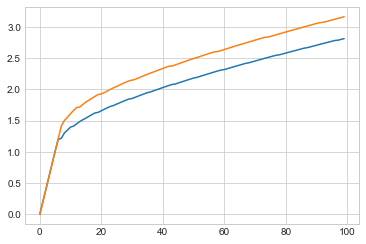

In [67]:
plt.plot(sol.c[0,:])
plt.plot(sol.c[1,:])

In [68]:
sol.delta
sol.it

258